In [1]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 

from tslearn.clustering import TimeSeriesKMeans, KernelKMeans
from tslearn.metrics import dtw

from tslearn.preprocessing import TimeSeriesScalerMeanVariance, TimeSeriesResampler
from tslearn.datasets import CachedDatasets

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder

from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
import seaborn as sbn

import networkx as nx

from sklearn.svm import SVC
from sklearn.feature_selection import RFE

import os

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn import datasets

In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The savefig.frameon rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The pgf.debug rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.level rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
In C:\anaconda-3.5.2.0\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The verbose.fileo rcparam was deprecated in Matplotlib 3.1 and will be removed in 3.3.
C:\anaconda-3.5.2.0\lib\site-packages\tslearn\clustering\kmeans.py:17: UserWarning: Sci

In [2]:
os.listdir('../data/HER2/')

['H210122_SKBR3',
 'H210205_Set1',
 'H210205_Set2',
 'H210212_Set1',
 'H210212_Set2',
 'H210219_Set1',
 'H210219_Set2']

In [16]:
load = 'normalized' # or 'raw'

series_sel = pd.read_csv('../data/HER2/H210122_SKBR3/normalized/clover_all_cell.csv').columns[1:-3]

_datas = []
for dataset in os.listdir('../data/HER2'): 
    cl_path = '../data/HER2/' + dataset + '/' + load + '/clover_all_cell.csv'
    ms_path = '../data/HER2/' + dataset + '/' + load + '/mscarlet_all_cell.csv'
    _clover = pd.read_csv(cl_path)
    _mscarl = pd.read_csv(ms_path)
    _data = _clover.merge(_mscarl, on=['track_index', 'cell__treatment'], how='inner')
    _data = _data.assign(dataset=dataset)
    _datas.append(_data)
    
data = pd.concat(_datas, axis=0)

clover_sel = [f'{x}_x' for x in series_sel]
mscarl_sel = [f'{x}_y' for x in series_sel]

data = data.assign(drug = [x.split('_', maxsplit=5)[-1] for x in data.cell__treatment])
data = data.assign(cell_line = [x.split('_', maxsplit=5)[0] for x in data.cell__treatment])
data = data.assign(mutant = [x.split('_', maxsplit=5)[-2] for x in data.cell__treatment])

data.head()

,track_index,0.0_x,0.2_x,0.5_x,0.8_x,1.0_x,1.2_x,1.5_x,1.8_x,2.0_x,...,57.5_y,57.8_y,58.0_y,58.2_y,site_y,median_y,dataset,drug,cell_line,mutant
0,69_1000049620_skbr3_erk_akt__WT_untreated,0.784316,0.786841,0.603200,0.541081,0.458533,0.431992,0.712106,0.699950,0.730170,...,0.242807,0.127572,0.132009,0.047259,69,0.299107,H210122_SKBR3,untreated,skbr3,WT
1,2_1000028311_skbr3_erk_akt__WT_untreated,0.602541,0.605066,0.421425,0.605618,0.691947,0.672889,0.614016,0.661317,0.682537,...,0.557662,0.562536,0.564215,0.564624,2,0.693558,H210122_SKBR3,untreated,skbr3,WT
2,69_1000046124_skbr3_erk_akt__WT_untreated,0.777447,0.753066,0.476562,0.595350,0.605771,0.767272,0.737938,0.733756,0.776656,...,0.522485,0.451602,0.484998,0.550944,69,0.509604,H210122_SKBR3,untreated,skbr3,WT
3,0_1000000658_skbr3_erk_akt__WT_untreated,0.831403,0.652266,0.454141,0.696562,0.757371,0.882979,0.805273,0.936487,0.915338,...,0.779451,0.878771,0.866162,0.826636,0,0.607951,H210122_SKBR3,untreated,skbr3,WT
4,75_1000100136_skbr3_erk_akt__WT_untreated,0.165367,0.141473,0.447377,0.482309,0.478944,0.658566,0.682605,0.727898,0.744381,...,0.562468,0.551105,0.634450,0.626864,75,0.668938,H210122_SKBR3,untreated,skbr3,WT


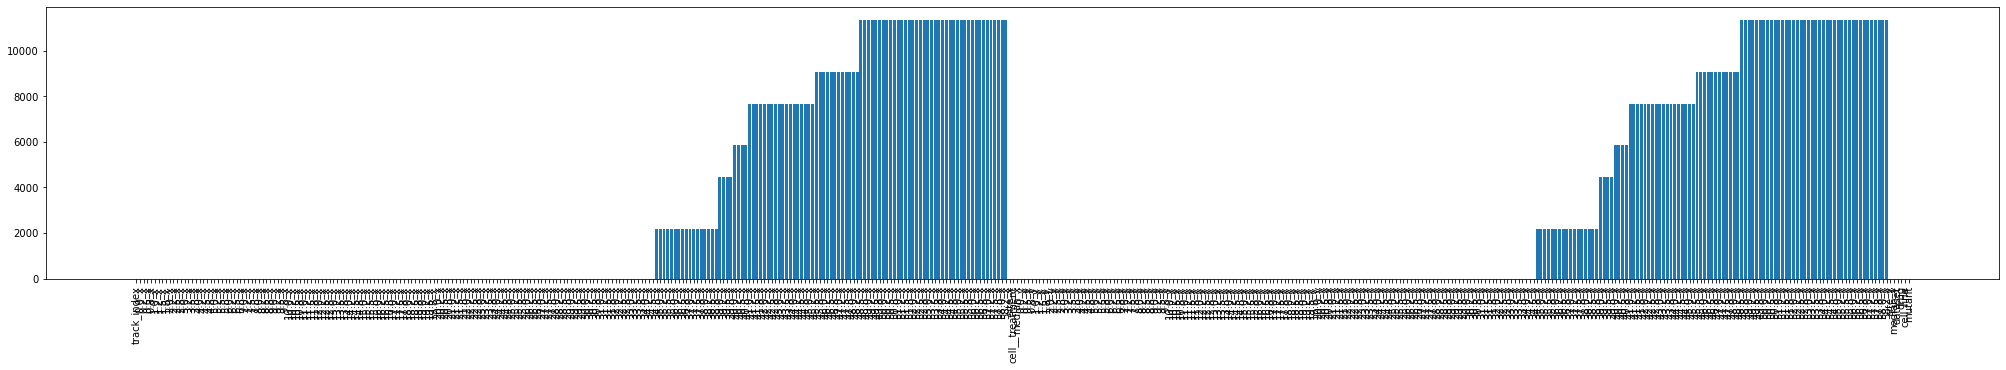

In [17]:
plt.figure(figsize=(35, 5))
plt.bar(x=data.columns, height=data.isna().sum())
plt.xticks(rotation=90)
plt.show()

In [18]:
data.drug.unique()

array(['untreated', '10nm_neratinib', '10ug_ml_trastuzumab'], dtype=object)

In [19]:
data = data[lambda x: x.drug.isin(['untreated', '10ug_ml_trastuzumab'])]
data.shape

(8702, 478)

In [20]:
data.drug.unique()

array(['untreated', '10ug_ml_trastuzumab'], dtype=object)

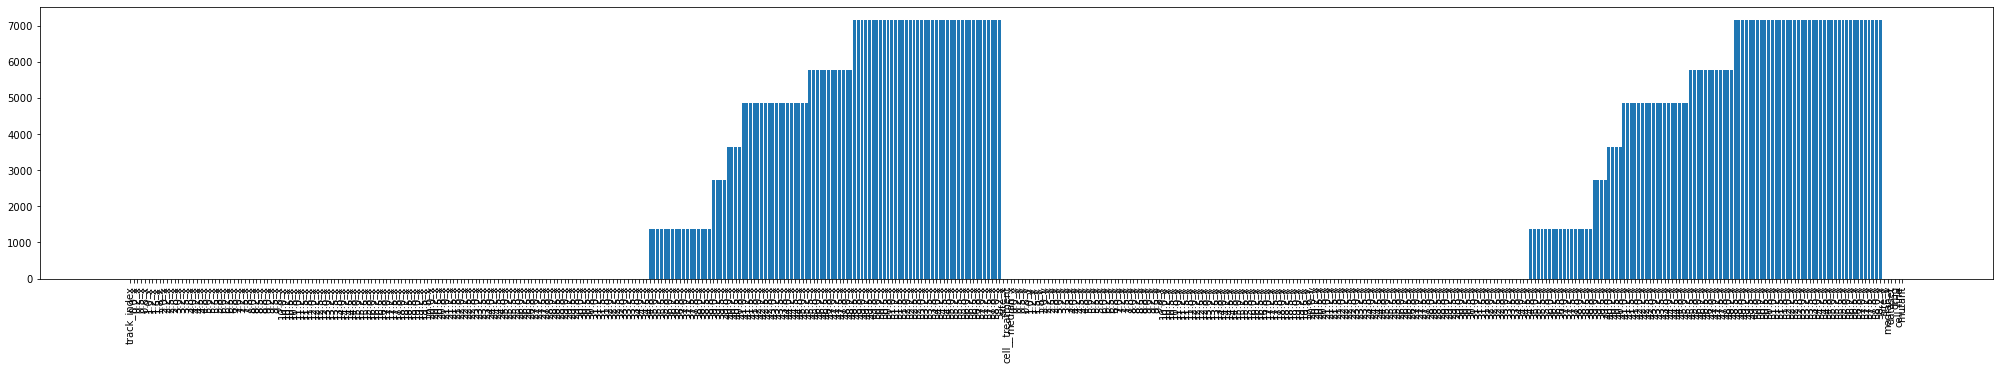

In [21]:
plt.figure(figsize=(35, 5))
plt.bar(x=data.columns, height=data.isna().sum())
plt.xticks(rotation=90)
plt.show()

In [22]:
# remove na
clover_sel = np.array(clover_sel)[~data[clover_sel].isna().any()]
mscarl_sel = np.array(mscarl_sel)[~data[mscarl_sel].isna().any()]

In [23]:
#X_train = data[clover_sel]
X_train = np.stack([data[clover_sel], data[mscarl_sel]], axis=2)
print(X_train.shape)

# Make time series shorter
X_train = TimeSeriesResampler(sz=100).fit_transform(X_train)
sz = X_train.shape[1]
print(X_train.shape)
nclus = 25

(8702, 139, 2)
(8702, 100, 2)


In [24]:
km = TimeSeriesKMeans(n_clusters=nclus, verbose=True, random_state=0, metric='euclidean', n_jobs=8)
y_pred = km.fit_predict(X_train)

5.475 --> 4.164 --> 4.057 --> 4.013 --> 3.989 --> 3.975 --> 3.968 --> 3.963 --> 3.960 --> 3.959 --> 3.957 --> 3.956 --> 3.955 --> 3.954 --> 3.953 --> 3.952 --> 3.951 --> 3.951 --> 3.950 --> 3.949 --> 3.948 --> 3.947 --> 3.946 --> 3.946 --> 3.946 --> 3.945 --> 3.945 --> 3.945 --> 3.944 --> 3.944 --> 3.944 --> 3.944 --> 3.943 --> 3.943 --> 3.943 --> 3.943 --> 3.943 --> 3.942 --> 3.942 --> 3.942 --> 3.942 --> 3.942 --> 3.942 --> 3.942 --> 3.941 --> 3.941 --> 3.941 --> 3.941 --> 3.941 --> 3.941 --> 


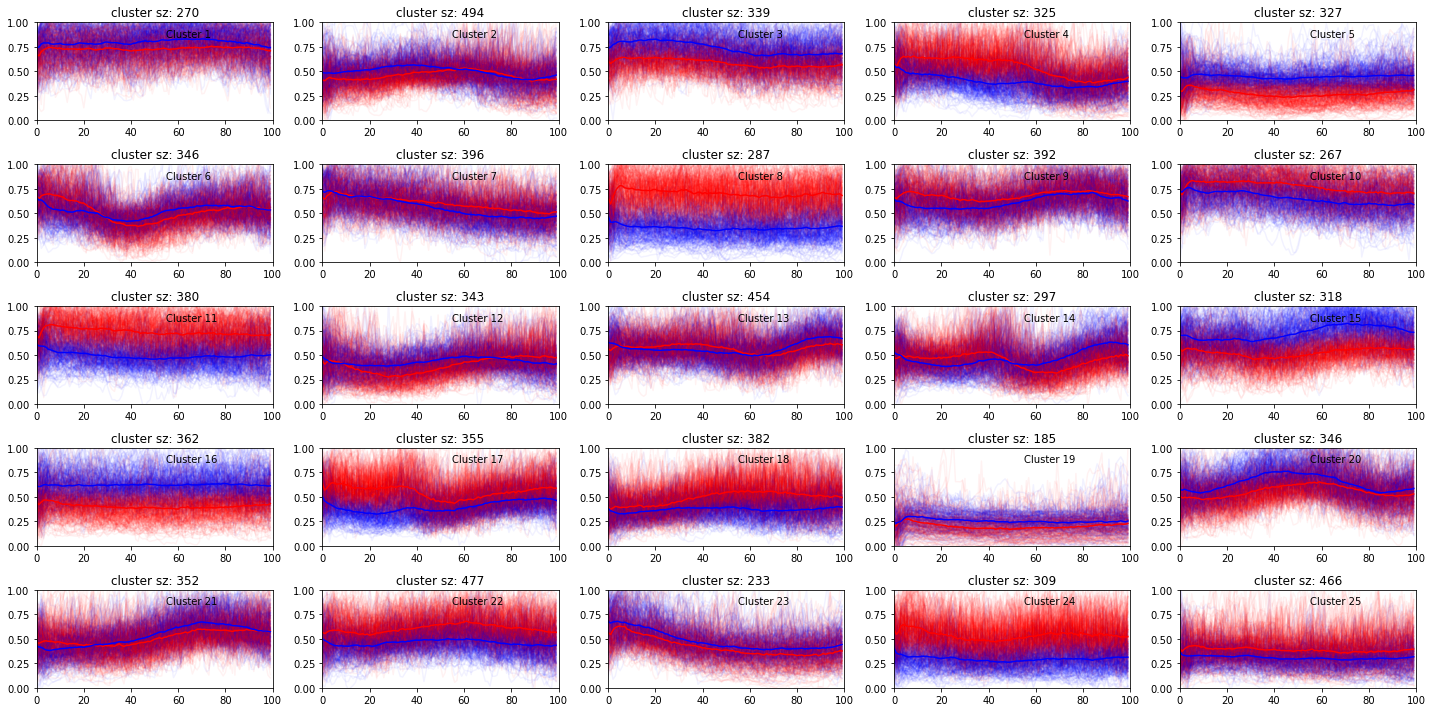

In [25]:
plt.figure(figsize=(20,10))
for yi in range(nclus):
    plt.subplot(5, 5, yi + 1)
    for xx in X_train[y_pred == yi][0:250]:
        plt.plot(xx[:,0], "r-", alpha=.05)
        plt.plot(xx[:,1], "b-", alpha=.05)
        
    plt.title(f'cluster sz: {len(X_train[y_pred == yi])}')
    plt.plot(km.cluster_centers_[yi][:,0], "r-", label='clover')
    plt.plot(km.cluster_centers_[yi][:,1], "b-", label='mscarlet')
    
    plt.xlim(0, sz)
    plt.ylim(0, 1)
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
             transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

In [26]:
lb = LabelEncoder()
y_trt = lb.fit_transform([f'{x}--{y}' for x,y in zip(data.cell__treatment.values, data.dataset.values)])

In [27]:
cm_cnts = {c:np.zeros(nclus) for c in lb.classes_} 

In [28]:
for i, clus, grp in zip(range(len(y_pred)), y_pred, y_trt) :
    cm_cnts[lb.classes_[grp]][clus] += 1
    
cm_prob = {k:v/np.sum(v) for k,v in cm_cnts.items()}

In [29]:
labels = [k for k,v in cm_prob.items()]
cm = np.stack([v for k,v in cm_prob.items()], axis=0)

In [30]:
cm.shape

(124, 25)

<Figure size 504x504 with 0 Axes>

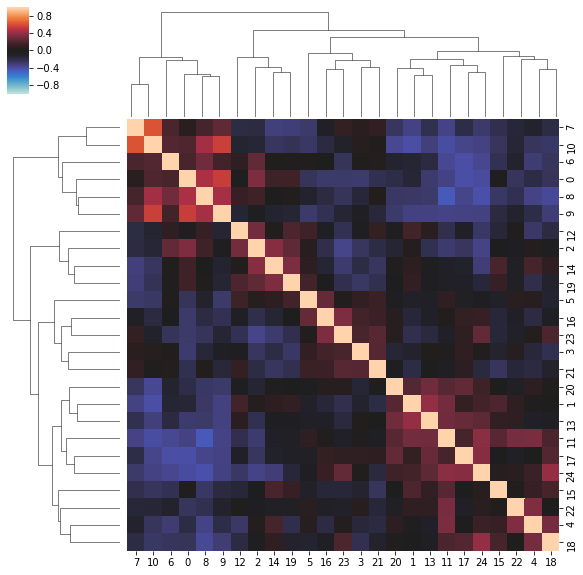

In [31]:
corr = np.corrcoef(cm, rowvar=False)

plt.figure(figsize=(7,7))
ax = sbn.clustermap(
    corr, 
    vmin=-1, vmax=1, center=0,
    square=True
)
plt.show()

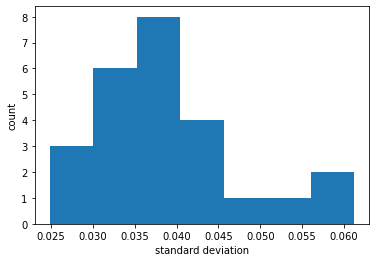

In [32]:
cm_stds = cm.std(axis=0)

plt.figure()
plt.hist(cm_stds, bins=7)
plt.ylabel('count')
plt.xlabel('standard deviation')
plt.show()

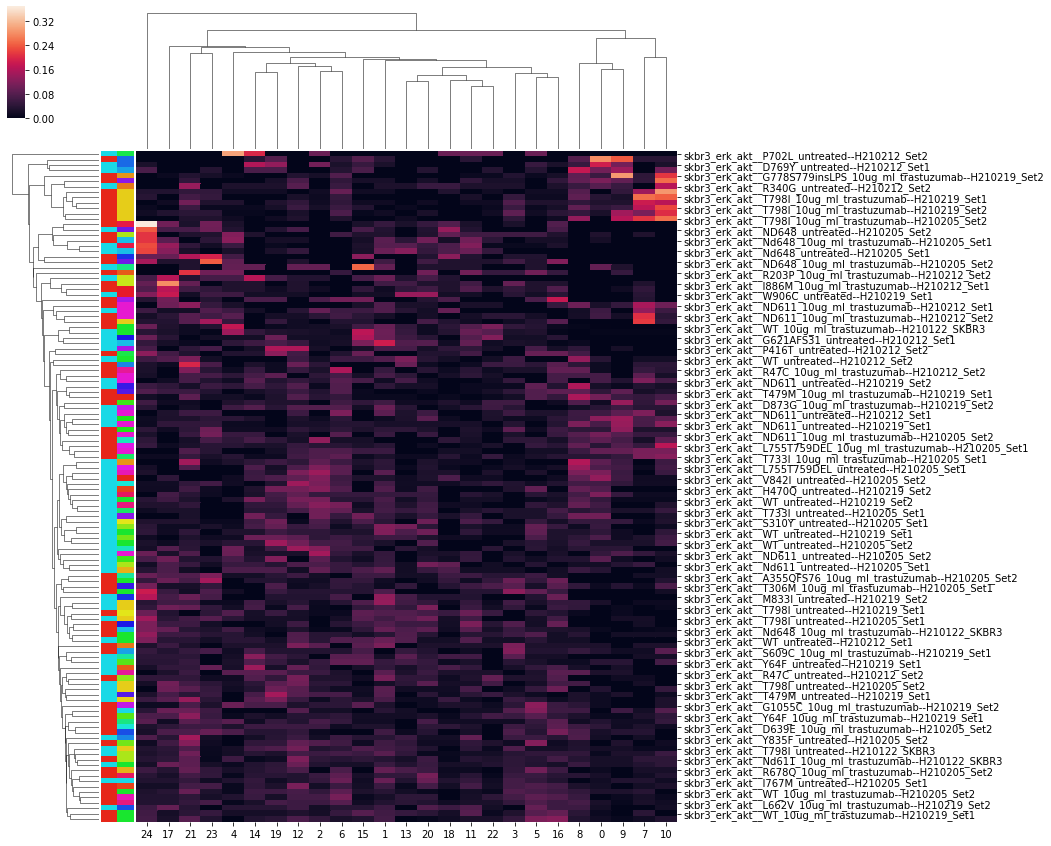

In [33]:
#drug = dict(zip(data.drug.unique(), "rbg"))
#row_colors = data.drug.map(drug)
#g = sbn.clustermap(cm, row_colors=row_colors)
# [x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]

drug = [x.split('--')[0].split('_')[-1] for x in labels]
lut = dict(zip(set(drug), sbn.hls_palette(len(set(drug)), l=0.5, s=0.8)))
row_colors = pd.DataFrame(drug)[0].map(lut)

#Create additional row_colors here
cell_line = [x.split('_')[4] for x in labels]
lut2 = dict(zip(set(cell_line), sbn.hls_palette(len(set(cell_line)), l=0.5, s=0.8)))
row_colors2 = pd.DataFrame(cell_line)[0].map(lut2)

df = pd.DataFrame(index=labels, data=cm)
sbn.clustermap(df, figsize=(12,15), row_colors=[row_colors, row_colors2]) 

#plt.ylabel('treatment')
#plt.yticks(ticks=plt.yticks()[0], labels=[str(x) for x in labels])
#plt.xlabel('cluster label')
plt.show()

# Dimensionality Reduction

In [34]:
pca = PCA(n_components=2)
PCs = pca.fit_transform(cm)

print('explained variance ratio:', pca.explained_variance_ratio_)
print('PC shape:', PCs.shape)
res = pd.DataFrame({'pc1': PCs[:,0], 'pc2':PCs[:,1], 'treatment':[x.split('--')[0].split('_')[-1] for x in lb.classes_], 'cell_line':[x.split('_')[4] for x in lb.classes_]})
res.head()

explained variance ratio: [0.25473839 0.1384762 ]
PC shape: (124, 2)


,pc1,pc2,treatment,cell_line
0,-0.094599,0.059086,trastuzumab,A355QFS76
1,-0.052131,-0.033239,untreated,A355QFS76
2,-0.016554,-0.014299,trastuzumab,D277H
3,0.032958,-0.088841,untreated,D277H
4,0.042533,0.037167,trastuzumab,D638H


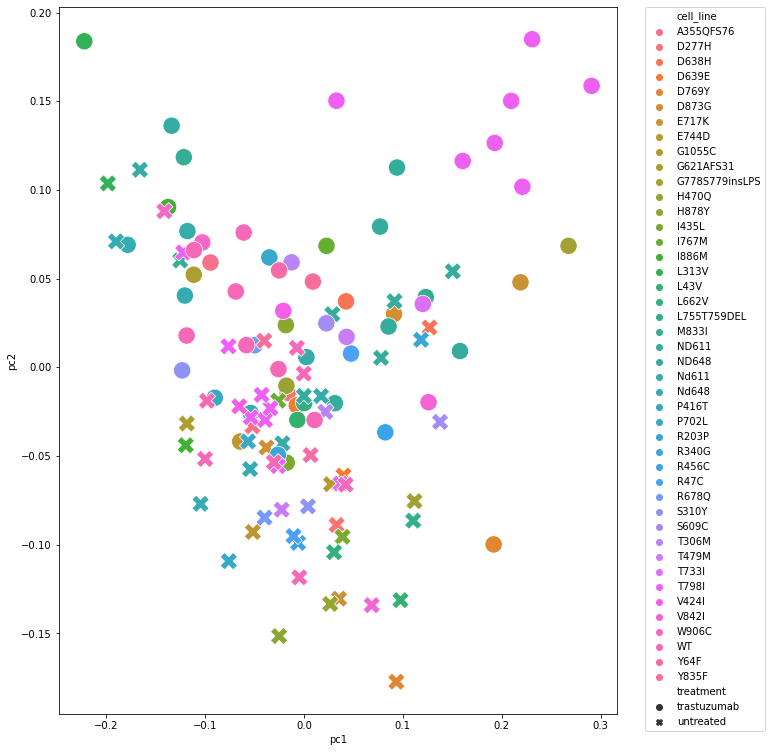

In [35]:
plt.figure(figsize=(10,13))
sbn.scatterplot(x='pc1', y='pc2', data=res, hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

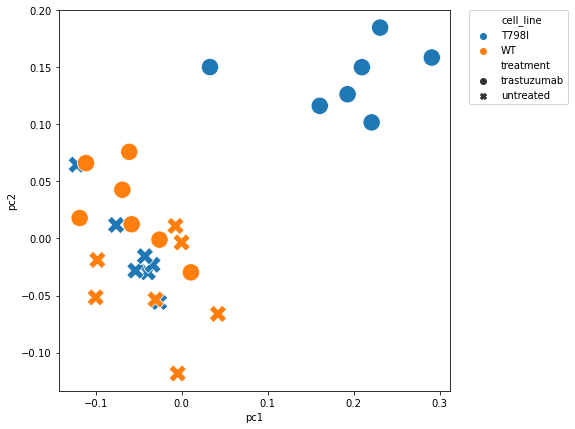

In [36]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='pc1', y='pc2', data=res[lambda x: (x.cell_line.isin(['WT', 'T798I']))], hue='cell_line', style='treatment', s=300)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [223]:
res.head()

,pc1,pc2,treatment,cell_line
0,-0.118267,-0.033145,neratinib,A355QFS76
1,0.065132,-0.037082,untreated,A355QFS76
2,-0.137833,0.002963,neratinib,D277H
3,0.178354,0.004942,untreated,D277H
4,-0.141118,0.026790,neratinib,D638H


In [38]:
res_ner = res[lambda x: (x.cell_line.isin(['WT', 'T798I']))]# & (x.treatment == 'neratinib')]

In [39]:
X = 5* res_ner[['pc1', 'pc2']].values
y = 1.*((res_ner.cell_line == 'WT') & (res_ner.treatment == '10ug_ml_trastuzumab')).values \
        + 2.* (res_ner.treatment == 'untreated').values

In [40]:
np.unique(y)

array([0., 2.])

Accuracy (train) for L1 logistic: 82.1% 
Accuracy (train) for L2 logistic (Multinomial): 82.1% 
Accuracy (train) for L2 logistic (OvR): 82.1% 
Accuracy (train) for Linear SVC: 82.1% 
Accuracy (train) for GPC: 82.1% 


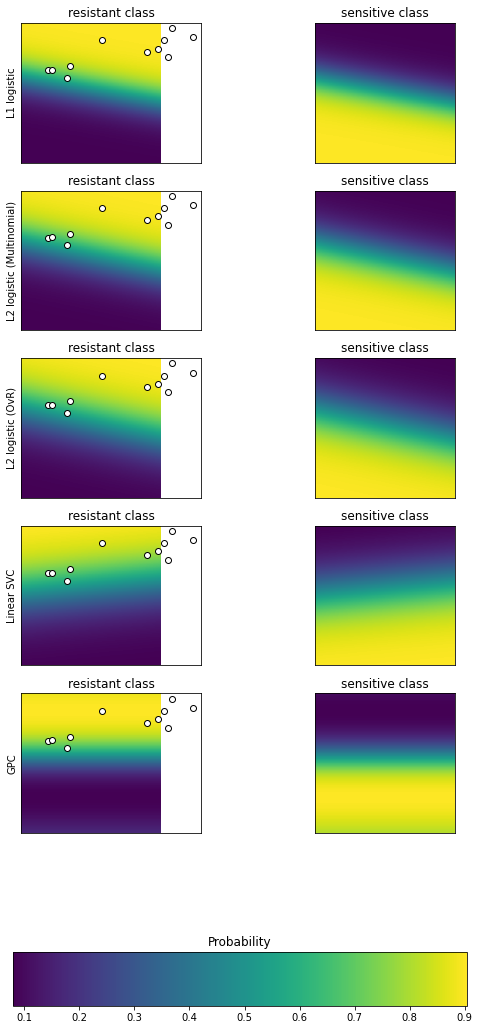

In [41]:
n_features = X.shape[1]

C = 10
kernel = 1.0 * RBF([1.0, 1.0])  # for GPC

# Create different classifiers.
classifiers = {
    'L1 logistic': LogisticRegression(C=C, penalty='l1',
                                      solver='saga',
                                      multi_class='multinomial',
                                      max_iter=10000),
    'L2 logistic (Multinomial)': LogisticRegression(C=C, penalty='l2',
                                                    solver='saga',
                                                    multi_class='multinomial',
                                                    max_iter=10000),
    'L2 logistic (OvR)': LogisticRegression(C=C, penalty='l2',
                                            solver='saga',
                                            multi_class='ovr',
                                            max_iter=10000),
    'Linear SVC': SVC(kernel='linear', C=C, probability=True,
                      random_state=0),
    'GPC': GaussianProcessClassifier(kernel)
}

n_classifiers = len(classifiers)

plt.figure(figsize=(3 * 3, n_classifiers * 3))
plt.subplots_adjust(bottom=.2, top=.95)

xx = np.linspace(-1, 1, 100)
yy = np.linspace(-1, 1, 100).T
xx, yy = np.meshgrid(xx, yy)
Xfull = np.c_[xx.ravel(), yy.ravel()]

class_names = ['resistant', 'sensitive', 'untreated']
for index, (name, classifier) in enumerate(classifiers.items()):
    classifier.fit(X, y)

    y_pred = classifier.predict(X)
    accuracy = accuracy_score(y, y_pred)
    print("Accuracy (train) for %s: %0.1f%% " % (name, accuracy * 100))

    # View probabilities:
    probas = classifier.predict_proba(Xfull)
    n_classes = np.unique(y_pred).size
    for k in range(n_classes):
        plt.subplot(n_classifiers, n_classes, index * n_classes + k + 1)
        plt.title("%s class" % class_names[k])
        if k == 0:
            plt.ylabel(name)
        imshow_handle = plt.imshow(probas[:, k].reshape((100, 100)),
                                   extent=(-1, 1, -1, 1), origin='lower')
        plt.xticks(())
        plt.yticks(())
        idx = (y_pred == k)
        if idx.any():
            plt.scatter(X[idx, 0], X[idx, 1], marker='o', c='w', edgecolor='k')

ax = plt.axes([0.15, 0.04, 0.7, 0.05])
plt.title("Probability")
plt.colorbar(imshow_handle, cax=ax, orientation='horizontal')

plt.show()

In [233]:
X_all = 5*res[['pc1', 'pc2']].values

In [234]:
y_hat = classifiers['Linear SVC'].predict_proba(X_all)

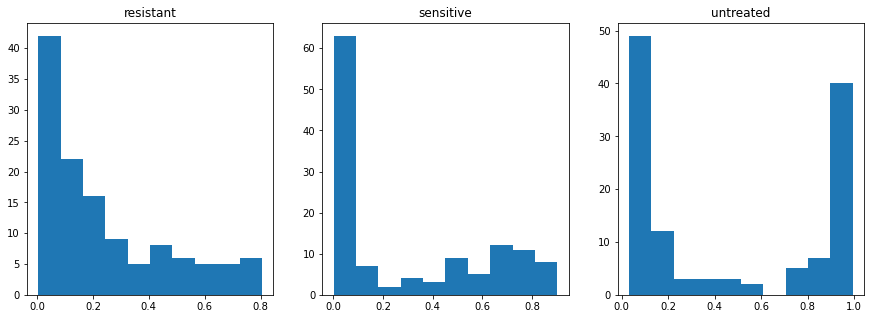

In [235]:
f, ax = plt.subplots(1,3, figsize=(15,5))
ax[0].hist(y_hat[:,0])
ax[0].set_title('resistant')
ax[1].hist(y_hat[:,1])
ax[1].set_title('sensitive')
ax[2].hist(y_hat[:,2])
ax[2].set_title('untreated')
plt.show()

In [236]:
pres = pd.DataFrame({'prob_res':y_hat[:,0], 'prob_sens':y_hat[:,1], 'prob_untreat':y_hat[:,2]})
res2 = pd.concat([res, pres], axis=1)
res2 = res2.assign(call=[['res','sens','untreat'][np.argmax([x,y,z])] for x,y,z in zip(res2.prob_res, res2.prob_sens, res2.prob_untreat)])
res2.head()

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,prob_untreat,call
0,-0.118267,-0.033145,neratinib,A355QFS76,0.489832,0.423780,0.086388,res
1,0.065132,-0.037082,untreated,A355QFS76,0.217927,0.036132,0.745940,untreat
2,-0.137833,0.002963,neratinib,D277H,0.285654,0.638355,0.075991,sens
3,0.178354,0.004942,untreated,D277H,0.024065,0.004842,0.971093,untreat
4,-0.141118,0.026790,neratinib,D638H,0.207710,0.714890,0.077401,sens


In [237]:
res2.groupby(['call', 'treatment'])[['cell_line']].count()

cell_line
call    treatment           
res     neratinib         17
        untreated          6
sens    neratinib         44
untreat neratinib          1
        untreated         56

In [244]:
res2[lambda x: x.prob_res > 0.6].sort_values('prob_res', ascending=False)

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,prob_untreat,call
33,-0.088283,-0.113284,untreated,L313V,0.805032,0.117902,0.077066,res
91,-0.088671,-0.109016,neratinib,T798I,0.795943,0.124951,0.079106,res
61,-0.054650,-0.112271,untreated,Nd648,0.786053,0.076684,0.137262,res
74,-0.064964,-0.096309,neratinib,R678Q,0.768324,0.103517,0.128160,res
70,-0.101553,-0.097168,neratinib,R456C,0.751997,0.176865,0.071137,res
90,-0.024481,-0.129231,neratinib,T798I,0.744077,0.051675,0.204248,res
53,-0.008488,-0.138799,untreated,ND648,0.708983,0.044197,0.246820,res
20,-0.064259,-0.067477,neratinib,G778S779insLPS,0.703212,0.140800,0.155988,res
105,0.007200,-0.151327,untreated,W906C,0.675276,0.037399,0.287325,res
89,-0.057592,-0.052975,neratinib,T798I,0.663984,0.147367,0.188649,res


In [246]:
res2[lambda x: x.prob_sens > 0.8].sort_values('prob_sens', ascending=False)

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,prob_untreat,call
55,-0.168198,0.115335,neratinib,Nd611,0.045309,0.900971,0.053720,sens
59,-0.175964,0.080517,neratinib,Nd648,0.059160,0.896512,0.044328,sens
30,-0.191536,0.036112,neratinib,I886M,0.078627,0.889997,0.031376,sens
109,-0.160383,0.067166,neratinib,WT,0.091953,0.848988,0.059059,sens
8,-0.153925,0.084191,neratinib,D769Y,0.084191,0.847295,0.068514,sens
62,-0.157725,0.054449,neratinib,P416T,0.113148,0.825928,0.060924,sens
32,-0.155873,0.054694,neratinib,L313V,0.116549,0.820362,0.063089,sens
106,-0.130848,0.175619,neratinib,WT,0.055557,0.819008,0.125435,sens
18,-0.142498,0.081580,neratinib,G621AFS31,0.106853,0.808302,0.084845,sens
26,-0.165064,0.025261,neratinib,I435L,0.145782,0.803577,0.050641,sens


In [152]:
res2[lambda x: x.prob_untreat > 0.75]

,pc1,pc2,treatment,cell_line,prob_res,prob_sens,prob_untreat
